### Movie lens data preprocessing

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import os
import random
import nltk
from functools import lru_cache
import math 
import sklearn.preprocessing
from sklearn.preprocessing import LabelEncoder

In [3]:
input_dir = 'E:\\NLP\\Movies'

path = os.path.join(input_dir, 'rating.csv')
df = pd.read_csv(path, usecols = ['userId', 'movieId', 'rating'])
df.head()


userId  movieId  rating
0       1        2     3.5
1       1       29     3.5
2       1       32     3.5
3       1       47     3.5
4       1       50     3.5

In [4]:
#shuffle reproducibly
ratings_df = df.sample(frac = 1, random_state = 1).reset_index(drop = True)
ratings_df.head()

userId  movieId  rating
0  123425      529     4.0
1  108287      947     5.0
2  109381     4179     4.0
3   64404      909     4.5
4  137309     1747     2.5

In [5]:
# Partitioning train/val according to behaviour of keras.Model.fit() when called with
# validation_split kwarg (which is to take validation data from the end as a contiguous
# chunk)

val_split = 0.25
n_ratings = len(ratings_df)
n_train = math.floor(n_ratings*(1-val_split))
itrain = ratings_df.index[:n_train]
ival = ratings_df.index[n_train:]

print("Number of ratings:", n_ratings)
print("Training set length", n_train)
print("Indexes of training:", itrain)
print("Indexes of validation:", len(ival))

Number of ratings: 20000263
Training set length 15000197
Indexes of training: RangeIndex(start=0, stop=15000197, step=1)
Indexes of validation: 5000066


In [6]:
# compactify movieid's

movie_encoder = LabelEncoder()

ratings_df['movieId'] = movie_encoder.fit_transform(ratings_df['movieId'])

# add centered target variable
ratings_df['y'] = ratings_df['rating']-ratings_df.loc[itrain, 'rating'].mean()

def compactify_ids(df, col, backup=True):
    encoder = LabelEncoder()
    if backup:
        df[col+'_orig'] = df[col]
    df[col] = encoder.fit_transform(df[col])
    
for col in ['movieId', 'userId']:
    compactify_ids(ratings_df, col, backup=col=='movieId')
    


In [7]:
ratings_df.head()


userId  movieId  rating        y  movieId_orig
0  123424      525     4.0  0.47437           525
1  108286      930     5.0  1.47437           930
2  109380     4085     4.0  0.47437          4085
3   64403      892     4.5  0.97437           892
4  137308     1683     2.5 -1.02563          1683

In [8]:
scale = 0

if scale:
    # Add version of target variable scale to [0, 1]
    yscaler = sklearn.preprocessing.MinMaxScaler()
    yscaler.fit(ratings_df.loc[itrain, 'rating'].values.reshape(-1, 1))
    ratings_df['y_unit_scaled'] = yscaler.transform(ratings_df['rating'].values.reshape(-1, 1))
    
ratings_df.head(20)

# save ratings file for further use
ratings_df.to_csv('ratings.csv', index = False)

In [14]:
def munge_title(title):
    i = title.rfind(' (')
    if i != -1:
        title = title[:i]
    for suff_word in ['The', 'A', 'An']:
        suffix = ', {}'.format(suff_word)
        if title.endswith(suffix):
            title = suff_word + ' ' + title[:-len(suffix)]
    return title

def get_year(title):
    l = title.rfind('(') + 1
    try:
        return int(title[l:l+4])
    except ValueError:
        print(title, end='\t')
        return 0


In [15]:
movie_df = pd.read_csv('movie.csv')
mdf = movie_df

# XXX: hack
assert mdf.loc[mdf.movieId==64997,'title'].iloc[0] == 'War of the Worlds (2005)'

mdf.loc[mdf.movieId==64997, 'title'] = 'War of the Worlds (2005)x'

mdf.head()
movie_df.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [112]:
df.head()

userId  movieId  rating
0       1        2     3.5
1       1       29     3.5
2       1       32     3.5
3       1       47     3.5
4       1       50     3.5

In [16]:
mdf['year'] = mdf['title'].map(get_year)
mdf.head()

Babylon 5	Millions Game, The (Das Millionenspiel)	Bicycle, Spoon, Apple (Bicicleta, cullera, poma)	Brazil: In the Shadow of the Stadiums	Slaying the Badger	Tatort: Im Schmerz geboren	National Theatre Live: Frankenstein	The Court-Martial of Jackie Robinson	In Our Garden	Stephen Fry In America - New World	Two: The Story of Roman & Nyro	Li'l Quinquin	A Year Along the Abandoned Road	Body/Cialo	Polskie g√≥wno	The Third Reich: The Rise & Fall	My Own Man	Moving Alan	Michael Laudrup - en Fodboldspiller	

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  year  
0  Adventure|Animation|Children|Comedy|Fantasy  1995  
1                   Adventure|Children|Fantasy  1995  
2                               Comedy|Romance  1995  
3                         Comedy|Drama|Romance  1995  
4                                       Comedy  1995

In [17]:
n_orig = len(mdf)

# There are some movies listed in movie.csv which have no ratings. Drop them.

whitelist = set(movie_encoder.classes_)

print(len(whitelist))

mdf = mdf[mdf['movieId'].isin(whitelist)].copy()

print("Went from {} movies to {} after filtering out movies with no ratings".format(n_orig, len(mdf)))

26744
Went from 27278 movies to 26744 after filtering out movies with no ratings


In [18]:
# New, compact movie Ids

mdf['movieId'] = movie_encoder.fit_transform(mdf['movieId'].values)

mdf = mdf.sort_values(by='movieId').reset_index(drop=True)

# By default use original title field (which includes year of release) as unique key

mdf['key'] = mdf['title']

# mdf['year'] = mdf['title'].map(get_year)

mdf['title'] = mdf['title'].map(munge_title)

# For movies whose munged title are unique, use it as their key

title_counts = mdf.groupby('title').size()

unique_titles = title_counts.index[title_counts == 1]

unique_ids = mdf.index[mdf.title.isin(unique_titles)]

mdf.loc[unique_ids, 'key'] = mdf.loc[unique_ids, 'title']

mdf['n_ratings'] = ratings_df.groupby('movieId').size()

mean_ratings = ratings_df.groupby('movieId')['rating'].mean()

mdf['mean_rating'] = mean_ratings



In [19]:
mdf.to_csv('movies.csv', index = False)

In [20]:
mdf.head()

movieId                        title  \
0        0                    Toy Story   
1        1                      Jumanji   
2        2             Grumpier Old Men   
3        3            Waiting to Exhale   
4        4  Father of the Bride Part II   

                                        genres  year  \
0  Adventure|Animation|Children|Comedy|Fantasy  1995   
1                   Adventure|Children|Fantasy  1995   
2                               Comedy|Romance  1995   
3                         Comedy|Drama|Romance  1995   
4                                       Comedy  1995   

                           key  n_ratings  mean_rating  
0                    Toy Story      49695     3.921240  
1                      Jumanji      22243     3.211977  
2             Grumpier Old Men      12735     3.151040  
3            Waiting to Exhale       2756     2.861393  
4  Father of the Bride Part II      12161     3.064592

In [21]:
ratings_df.head()

userId  movieId  rating        y
0  123425      525     4.0  0.47437
1  108287      930     5.0  1.47437
2  109381     4085     4.0  0.47437
3   64404      892     4.5  0.97437
4  137309     1683     2.5 -1.02563

In [2]:
# Setup. Import libraries and load dataframes for Movielens data.

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import random

tf.set_random_seed(1); np.random.seed(1); random.seed(1) # Set random seeds for reproducibility

# input_dir = '../input'
# ratings_path = os.path.join(input_dir, 'rating.csv')

ratings_df = pd.read_csv('ratings.csv', usecols=['userId', 'movieId', 'rating', 'y'])

movies_df = pd.read_csv('movies.csv', usecols=['movieId', 'title', 'year'])

df_new = ratings_df.merge(movies_df, on='movieId').sort_values(by='userId')
df_new = df_new.sample(frac=1, random_state=1) # Shuffle

df_new.sample(5, random_state=1)


userId  movieId  rating        y                      title  year
12904240   85731     1883     4.5  0.97437                  Labyrinth  1986
6089380    45008     1221     4.5  0.97437  Femme Nikita, La (Nikita)  1990
17901393  125144     3948     4.0  0.47437                  The Alamo  1960
9024816   122230     3027     3.5 -0.02563                Toy Story 2  1999
11655659   21156     5202     3.0 -0.52563   My Big Fat Greek Wedding  2002

In [7]:
df_new.head()
df_new['userId'].nunique()
df_new['movieId'].nunique()

26744

## Implementing Embedding Layers to compare with basic baseline model

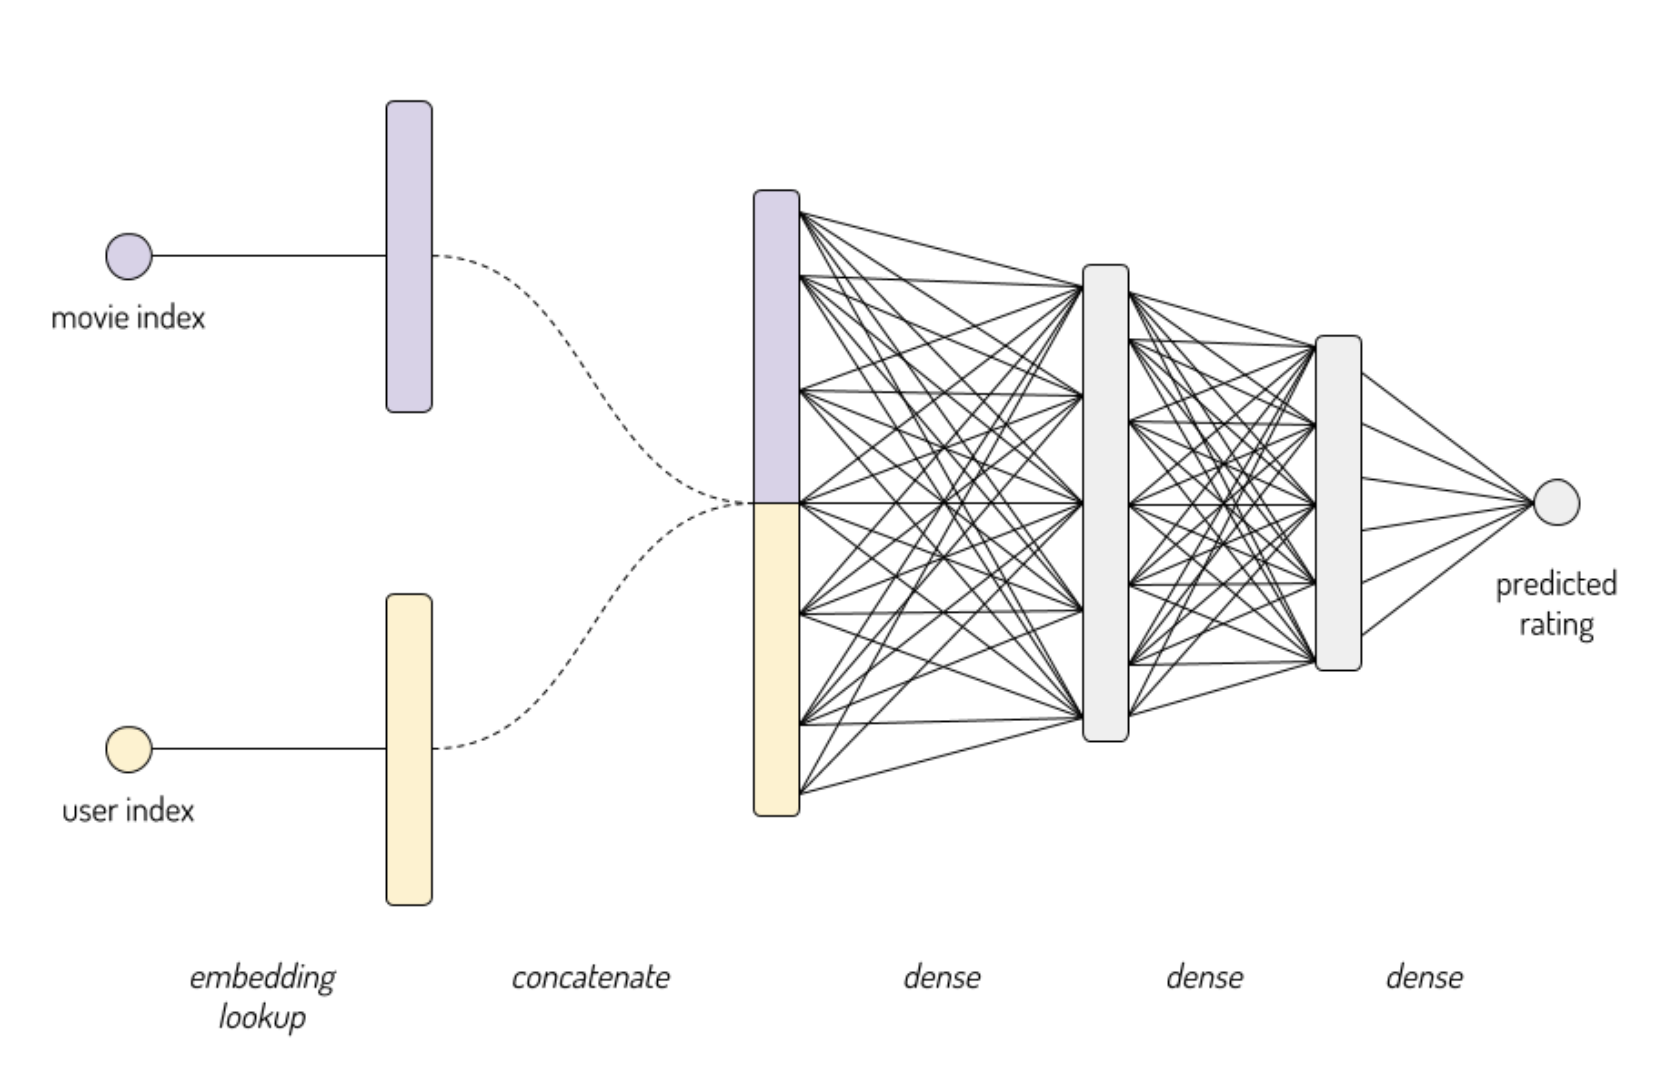

In [24]:
hidden_units = (32, 4)

movie_embedding_size = 8
user_embedding_size = 8

# Each instance will consist of two inputs: a single user id, and a single movie id
user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')

#Embedding layers

user_embedded = keras.layers.Embedding(df_new.userId.max()+1, user_embedding_size, 
                                       input_length=1, name = 'user_embedding')(user_id_input)


movie_embedded = keras.layers.Embedding(df_new.movieId.max()+1, movie_embedding_size, 
                                       input_length=1, name = 'movie_embedding')(movie_id_input)

# Concatenate the embeddings (and remove the useless extra dimension)

concatenated = keras.layers.Concatenate()([user_embedded, movie_embedded])

out = keras.layers.Flatten()(concatenated)

# Add one or more hidden layers

for n_hidden in hidden_units:
    out = keras.layers.Dense(n_hidden, activation='relu')(out)
    
# A single output: our predicted rating

out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

model = keras.Model(inputs = [user_id_input, movie_id_input],
                   outputs = out)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 8)         1107952     user_id[0][0]                    
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 8)         213952      movie_id[0][0]                   
__________________________________________________________________________________________________
concatenat

### Training model

In [25]:
model.compile(tf.train.AdamOptimizer(0.005), 
              loss = 'MSE', metrics = ['MAE'])

In [26]:

hist = model.fit([df_new.userId, df_new.movieId], df_new.y, 
                 batch_size=5000, epochs=20, verbose=0, validation_split=0.05)

### Baseline Model

In [27]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

train, val = train_test_split(df_new, test_size = .25, random_state = 42)

def get_metrics(y_true, y_pred):
    return metrics.mean_absolute_error(y_true, y_pred), metrics.mean_squared_error(y_true, y_pred)

mean_rating = train['rating'].mean()

print("Average rating in training set is {:.2f} stars".format(mean_rating))

Average rating in training set is 3.53 stars


In [28]:
y_true = val['rating'].values

mean_val = np.full(y_true.shape, mean_rating)

mae, mse = get_metrics(y_true, mean_val)

print("Always predicting global average rating results in Mean Absolute Error={:.2f}, Mean Squared Error={:.2f}".format(
    mae, mse))



Always predicting global average rating results in Mean Absolute Error=0.84, Mean Squared Error=1.11


In [36]:
movies = movies_df.copy().set_index('movieId')

mean_per_movie = train.groupby('movieId')['rating'].mean()
movies['mean_rating'] = mean_per_movie

ratings_per_movie = train.groupby('movieId').size()
movies['n_ratings'] = ratings_per_movie

# There are a few movies in the validation set not present in the training set. We'll just use the global
# mean rating in their case.

y_movie_mean = val.join(mean_per_movie, on='movieId', rsuffix='mean')['ratingmean'].fillna(mean_rating).values

mae, mse = get_metrics(y_true, y_movie_mean)

print("Predicting mean per movie results in Mean Absolute Error={:.2f}, Mean Squared Error={:.2f}".format(mae, mse))

Predicting mean per movie results in Mean Absolute Error=0.73, Mean Squared Error=0.89


In [41]:
val.columns

Index(['userId', 'movieId', 'rating', 'y', 'title', 'year'], dtype='object')

### Plot comparing Baseline model and Embedding Model designed

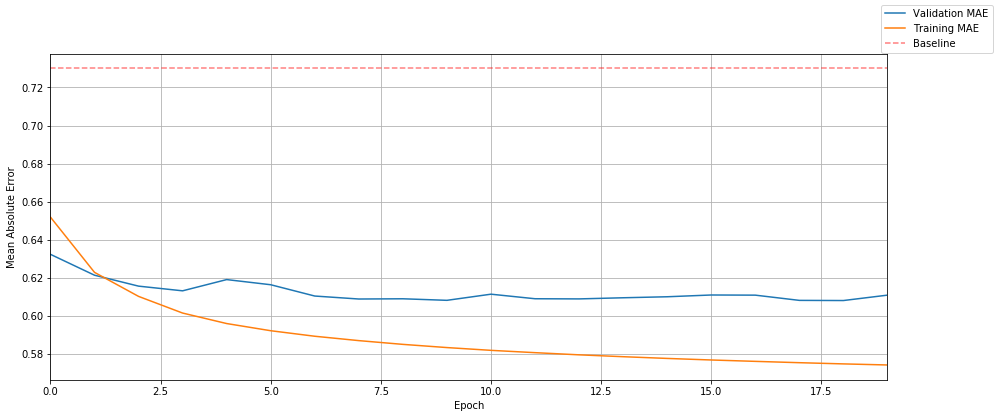

In [47]:
#Here's a plot of our embedding model's absolute error over time. 
#For comparison, our best baseline (predicting the average rating per movie) is marked with a dotted line:

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(hist.epoch, hist.history['val_mean_absolute_error'], label='Validation MAE')
ax.plot(hist.epoch, hist.history['mean_absolute_error'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=hist.epoch[-1])
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='--', label='Baseline', color='red', alpha=.5)
ax.grid()
fig.legend();

In [48]:
# Save training history for later comparison
hdf = pd.DataFrame(dict(
    epoch=hist.epoch,
    val_mae=hist.history['val_mean_absolute_error'],
    train_mae=hist.history['mean_absolute_error'],
))
hdf.to_csv('history-1.csv')

Compared to the baseline, we were able to get our average error down by more than .1 stars (or about 15%). Not bad!

### Example predictions:
Let's try some example predictions as a sanity check. We'll start by picking out a specific user from the dataset at random.


In [58]:
ratings_per_user = df_new.groupby('userId').size()

uid = ratings_per_user[ratings_per_user < 30].sample(1, random_state=42).index[0]

user_ratings = df_new[df_new.userId == uid]

print(" User #{} has rated #{} movies (avg. rating = {:.1f}):".format(uid, len(user_ratings), user_ratings['rating'].mean()))

cols = ['userId', 'movieId', 'rating', 'title', 'year']
user_ratings.sort_values(by='rating', ascending=False)[cols]

 User #135617 has rated #27 movies (avg. rating = 4.1):


userId  movieId  rating  \
6257797   135617     1171     5.0   
10195762  135617     7041     5.0   
2904741   135617      257     5.0   
2589851   135617     5853     5.0   
2546114   135617     4897     5.0   
167029    135617     1184     4.5   
1072383   135617      161     4.5   
1542013   135617      891     4.5   
9415993   135617     5281     4.5   
670271    135617     1058     4.5   
4584292   135617     3902     4.5   
18657835  135617     4908     4.5   
2632871   135617     2543     4.0   
5211099   135617     1457     4.0   
4358444   135617     2614     4.0   
1276387   135617      817     4.0   
572417    135617     1224     4.0   
2956492   135617     1345     4.0   
9687050   135617     6429     4.0   
9241565   135617     1068     4.0   
10805692  135617     1471     3.5   
5307956   135617     4964     3.5   
9743715   135617     2555     3.5   
5977590   135617     1833     3.0   
8417496   135617      166     3.0   
7582870   135617      548     3.0   
8819835   135617      170     3.0   

                                                      title  year  
6257797      Star Wars: Episode V - The Empire Strikes Back  1980  
10195762      The Lord of the Rings: The Return of the King  2003  
2904741                  Star Wars: Episode IV - A New Hope  1977  
2589851               The Lord of the Rings: The Two Towers  2002  
2546114   The Lord of the Rings: The Fellowship of the Ring  2001  
167029           Star Wars: Episode VI - Return of the Jedi  1983  
1072383                                           Desperado  1995  
1542013                                  North by Northwest  1959  
9415993        Star Wars: Episode II - Attack of the Clones  2002  
670271                         Monty Python's Life of Brian  1979  
4584292    Crouching Tiger, Hidden Dragon (Wo hu cang long)  2000  
18657835                                          The Party  1968  
2632871           Star Wars: Episode I - The Phantom Menace  1999  
5211099                                 Grosse Pointe Blank  1997  
4358444                South Park: Bigger, Longer and Uncut  1999  
1276387                                              Ransom  1996  
572417                                            Chinatown  1974  
2956492                       Star Trek IV: The Voyage Home  1986  
9687050   Pirates of the Caribbean: The Curse of the Bla...  2003  
9241565                                             Platoon  1986  
10805692        Austin Powers: International Man of Mystery  1997  
5307956                               M*A*S*H (a.k.a. MASH)  1970  
9743715                                            Superman  1978  
5977590                                          Armageddon  1998  
8417496                                        First Knight  1995  
7582870                                The Three Musketeers  1993  
8819835                                     Johnny Mnemonic  1995

User 135617 has given out two perfect ratings to the movies Airplane! and Airplane II: The Sequel. Great choices! Perhaps they'd also enjoy the The Naked Gun series - another series of spoof films starring Leslie Nielsen.

We don't have as much evidence about what this user hates. Rather than extrapolating from their few low ratings, a better indication of this user's dislikes might be the kinds of movies they haven't even rated. Let's also throw in a couple examples of movies that this user seems unlikely to ever watch, according to their rating history.

In [60]:
candidate_movies = movies[
    movies.title.str.contains('Naked Gun')
    | (movies.title == 'The Sisterhood of the Traveling Pants')
    | (movies.title == 'Lilo & Stitch')
].copy()

preds = model.predict([
    [uid] * len(candidate_movies), # User ids 
    candidate_movies.index, # Movie ids
])
# NB: Remember we trained on 'y', which was a version of the rating column centered on 0. To translate
# our model's output values to the original [0.5, 5] star rating scale, we need to 'uncenter' the
# values, by adding the mean back

row = df_new.iloc[0] # The difference between rating and y will be the same for all rows, so we can just use the first
y_delta = row.rating - row.y

candidate_movies['predicted_rating'] = preds + y_delta

# Add a column with the difference between our predicted rating (for this user) and the movie's
# overall average rating across all users in the dataset.
candidate_movies['delta'] = candidate_movies['predicted_rating'] - candidate_movies['mean_rating']
candidate_movies.sort_values(by='delta', ascending=False)

title  year  mean_rating  \
movieId                                                                      
5347                                      Lilo & Stitch  2002     3.491631   
3776             The Naked Gun 2 1/2: The Smell of Fear  1991     3.128363   
3775     The Naked Gun: From the Files of Police Squad!  1988     3.574836   
366                  Naked Gun 33 1/3: The Final Insult  1994     2.960026   
10138             The Sisterhood of the Traveling Pants  2005     3.356551   

         n_ratings  predicted_rating     delta  
movieId                                         
5347        3465.0          3.707279  0.215648  
3776        3494.0          3.191730  0.063367  
3775        5492.0          3.620164  0.045328  
366        10682.0          2.961354  0.001327  
10138        603.0          2.683496 -0.673054